In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_ivp

from models import *
import stars

from stars.rto.master_vkc import MasterVKC
from stars.rto.reactions import Component, Kinetics

%load_ext autoreload
%autoreload 2

# Generate Synthetic Data

Use Cinar (2011) reaction model: 
\begin{align*}
1.0 Oil + 4.00 O_2 &\rightarrow 10.00 Coke_1 + 22.389 H_2O  \\
1.0 Coke_1 + 1.50 O_2 &\rightarrow 1.0CO + 1.0 CO_2  \\
1.0 Coke_1 &\rightarrow 2.0 Coke_2 \\
1.0 Coke_2 + 1.4375 O_2 &\rightarrow 0.5 CO + 1.0 CO_2
\end{align*} 

Run for heating rates: 2, 3, 5, 6, 10, 12, 15, 16, 20, 25, 30 C/min. Use subsets of this data for evaluating interpolation and extrapolation models. 

Also run STARS models for two non-linear heating curves. 


In [2]:
# Setup parameters for all runs

TFINAL = 300
TEMP_MAX = 750
T0 = 15.0
O2_init = 0.21
So = 0.1

IC_dict = {'Oil': So, 'O2': O2_init, 'Temp': T0}
exe_path = '"C:\\Program Files (x86)\\CMG\\STARS\\2017.10\\Win_x64\\EXE\\st201710.exe"'

# Build STARS reactions
comp_names = ['Oil', 'Coke1', 'Coke2', 'O2', 'H2O', 'CO', 'CO2']
stars_components = stars.get_component_dict(comp_names)

REAC_COEFFS = np.array([[1.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0, 1.5, 0.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                       [0.0, 0.0, 1.0, 1.4375, 0.0, 0.0, 0.0]])
PROD_COEFFS = np.array([[0.0, 10.0, 0.0, 0.0, 22.389, 0.0, 0.0],
                       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0],
                       [0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0]])
REAC_ORDERS = 1.0*np.greater(REAC_COEFFS,0)
PREEXP_FAC = [1e-1, 2.5e3, 2.5e3, 2e-2]
ACT_ENERGY = [2.3e4, 6.7e4, 7.0e4, 9.5e4]
RENTH = [5.97e5, 1e6, 0.0, 4.85e6]

# Assemble STARS reactions list
req_comps = ['Oil', 'O2', 'H2O', 'CO', 'CO2', 'N2'] # required components
comp_names_aug = comp_names + [c for c in req_comps if c not in comp_names]
phases = [stars_components[c].phase for c in comp_names_aug] # get phases
comp_names_srtd = [c for _, c in sorted(zip(phases, comp_names_aug))] # sort comp_names according to phase
comp_names_inds = [comp_names_aug.index(c) for c in comp_names_srtd]

stars_reactions = []
num_pad = len(comp_names_aug) - len(comp_names)
for i in range(4):
    storeac = np.pad(REAC_COEFFS[i,:],(0,num_pad))
    stoprod = np.pad(PROD_COEFFS[i,:],(0,num_pad))
    rorder = np.pad(REAC_ORDERS[i,:],(0,num_pad))

    stars_reactions.append(stars.Kinetics(NAME="RXN"+str(i+1),
                            STOREAC=storeac[comp_names_inds].tolist(),
                            STOPROD=stoprod[comp_names_inds].tolist(),
                            RORDER=rorder[comp_names_inds].tolist(),
                            FREQFAC=PREEXP_FAC[i], 
                            EACT=ACT_ENERGY[i],
                            RENTH=RENTH[i])
                            )
    

In [3]:
# Run example data

exp_dir = 'namla_example_data'
heating_rates = [2.0, 3.0, 5.0, 10.0, 12.0, 15.0, 20.0]

            
# Run RTO simulations
for hr in heating_rates:
    
    TIME = np.arange(0,TFINAL+1)
    TEMP = np.minimum(hr*TIME + T0, TEMP_MAX)
    HEATING_DATA = {'Time':TIME, 'Temp':TEMP}
    
    # Run STARS simulation
    data_folder = os.path.join('datasets','synthetic',exp_dir)
    cd_path = os.path.join(data_folder,str(hr))
    if not os.path.exists(cd_path):
        os.makedirs(cd_path)
    kc = MasterVKC(folder_name = os.path.join(cd_path,''))
    
    write_dict = {
                'COMPS': stars_components, 
                'REACTS': stars_reactions, 
                'IC_dict': IC_dict, 
                'HEATING_DATA': HEATING_DATA,
                'TFINAL': HEATING_DATA['Time'][-1],
                'O2_con_in': IC_dict['O2']
                }
    
    kc.write_dat_file(**write_dict)
    kc.run_dat_file(exe_path, cd_path)
    
    # Save effluence data
    t, ydict = kc.get_reaction_dict()
    df_out = pd.DataFrame()
    df_out['Time'] = t*60
    df_out['Oil'] = ydict['Oil']
    df_out['O2'] = ydict['O2']
    df_out['H2O'] = ydict['H2O']
    df_out['CO'] = ydict['CO']
    df_out['CO2'] = ydict['CO2']
    df_out['N2'] = ydict['N2']
    df_out['Temp'] = ydict['Temp']
    df_out.to_excel(os.path.join(data_folder, str(hr) + '.xls'))
    
    # Print effluence and temperature data to figures
    plt.plot(t, ydict['O2']*100)
    plt.plot(t, ydict['CO']*100)
    plt.plot(t, ydict['CO2']*100)
    plt.plot(t, ydict['N2']*100)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [% mol]')
    plt.title('Effluence - Heating Rate=' + str(hr))
    plt.legend(['O2', 'CO', 'CO2', 'N2'])
    plt.savefig(os.path.join(cd_path, 'effluence.png'))
    plt.close()
    
    plt.plot(t, ydict['Temp'])
    plt.xlabel('Time [min]')
    plt.ylabel('Temperature [C]')
    plt.title('Temperature - Heating Rate='+str(hr))
    plt.savefig(os.path.join(cd_path, 'temperature.png'))
    plt.close()
    

In [4]:
# Run interpolation cases
exp_dir = 'namla_interpolation_data'
heating_rates = [6.0, 16.0]

for hr in heating_rates:
    
    TIME = np.arange(0,TFINAL+1)
    TEMP = np.minimum(hr*TIME + T0, TEMP_MAX)
    HEATING_DATA = {'Time':TIME, 'Temp':TEMP}
    
    # Run STARS simulation
    data_folder = os.path.join('datasets','synthetic',exp_dir)
    cd_path = os.path.join(data_folder,str(hr))
    if not os.path.exists(cd_path):
        os.makedirs(cd_path)
    kc = MasterVKC(folder_name = os.path.join(cd_path,''))
    
    write_dict = {
                'COMPS': stars_components, 
                'REACTS': stars_reactions, 
                'IC_dict': IC_dict, 
                'HEATING_DATA': HEATING_DATA,
                'TFINAL': HEATING_DATA['Time'][-1],
                'O2_con_in': IC_dict['O2']
                }
    
    kc.write_dat_file(**write_dict)
    kc.run_dat_file(exe_path, cd_path)
    
    # Save effluence data
    t, ydict = kc.get_reaction_dict()
    df_out = pd.DataFrame()
    df_out['Time'] = t*60
    df_out['Oil'] = ydict['Oil']
    df_out['O2'] = ydict['O2']
    df_out['H2O'] = ydict['H2O']
    df_out['CO'] = ydict['CO']
    df_out['CO2'] = ydict['CO2']
    df_out['N2'] = ydict['N2']
    df_out['Temp'] = ydict['Temp']
    df_out.to_excel(os.path.join(data_folder, str(hr) + '.xls'))
    
    # Print effluence and temperature data to figures
    plt.plot(t, ydict['O2']*100)
    plt.plot(t, ydict['CO']*100)
    plt.plot(t, ydict['CO2']*100)
    plt.plot(t, ydict['N2']*100)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [% mol]')
    plt.title('Effluence - Heating Rate=' + str(hr))
    plt.legend(['O2', 'CO', 'CO2', 'N2'])
    plt.savefig(os.path.join(cd_path, 'effluence.png'))
    plt.close()
    
    plt.plot(t, ydict['Temp'])
    plt.xlabel('Time [min]')
    plt.ylabel('Temperature [C]')
    plt.title('Temperature - Heating Rate='+str(hr))
    plt.savefig(os.path.join(cd_path, 'temperature.png'))
    plt.close()

In [5]:
# Run extrapolation heating rates
exp_dir = 'namla_extrapolation_data'
heating_rates = [25.0, 30.0]

for hr in heating_rates:
    
    TIME = np.arange(0,TFINAL+1)
    TEMP = np.minimum(hr*TIME + T0, TEMP_MAX)
    HEATING_DATA = {'Time':TIME, 'Temp':TEMP}
    
    # Run STARS simulation
    data_folder = os.path.join('datasets','synthetic',exp_dir)
    cd_path = os.path.join(data_folder,str(hr))
    if not os.path.exists(cd_path):
        os.makedirs(cd_path)
    kc = MasterVKC(folder_name = os.path.join(cd_path,''))
    
    write_dict = {
                'COMPS': stars_components, 
                'REACTS': stars_reactions, 
                'IC_dict': IC_dict, 
                'HEATING_DATA': HEATING_DATA,
                'TFINAL': HEATING_DATA['Time'][-1],
                'O2_con_in': IC_dict['O2']
                }
    
    kc.write_dat_file(**write_dict)
    kc.run_dat_file(exe_path, cd_path)
    
    # Save effluence data
    t, ydict = kc.get_reaction_dict()
    df_out = pd.DataFrame()
    df_out['Time'] = t*60
    df_out['Oil'] = ydict['Oil']
    df_out['O2'] = ydict['O2']
    df_out['H2O'] = ydict['H2O']
    df_out['CO'] = ydict['CO']
    df_out['CO2'] = ydict['CO2']
    df_out['N2'] = ydict['N2']
    df_out['Temp'] = ydict['Temp']
    df_out.to_excel(os.path.join(data_folder, str(hr) + '.xls'))
    
    # Print effluence and temperature data to figures
    plt.plot(t, ydict['O2']*100)
    plt.plot(t, ydict['CO']*100)
    plt.plot(t, ydict['CO2']*100)
    plt.plot(t, ydict['N2']*100)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [% mol]')
    plt.title('Effluence - Heating Rate=' + str(hr))
    plt.legend(['O2', 'CO', 'CO2', 'N2'])
    plt.savefig(os.path.join(cd_path, 'effluence.png'))
    plt.close()
    
    plt.plot(t, ydict['Temp'])
    plt.xlabel('Time [min]')
    plt.ylabel('Temperature [C]')
    plt.title('Temperature - Heating Rate='+str(hr))
    plt.savefig(os.path.join(cd_path, 'temperature.png'))
    plt.close()

In [6]:
# Run nonlinear heating curves
exp_dir = 'namla_arbitrary_data'
Time = np.arange(0,TFINAL,1)
n_time = Time.shape[0]
heating_schedule1 = np.asarray([15.0]*20 + [2.5]*40 + [-4.5]*90 + [9.5]*(n_time-150)) # Curve 1

hrs1 = 5.0 + 5*np.sin(Time[:100]/2/np.pi)
hrs2 = -1.5 + 3*np.sin(Time[100:200]/2/np.pi)
hrs3 = 3.5 + 5*np.sin(Time[200:]/2/np.pi)
heating_schedule2 = hrs1.tolist() + hrs2.tolist() + hrs3.tolist()

hr_list = [heating_schedule1, heating_schedule2]

# Run STARS simulation
for i, hr in enumerate(hr_list):
    
    TIME = np.arange(0,TFINAL+1)
    TEMP = np.minimum(cumtrapz(hr, Time, initial=T0), TEMP_MAX)
    TEMP = np.interp(TIME, Time, TEMP)
    HEATING_DATA = {'Time':TIME, 'Temp': TEMP}
    
    # Run STARS simulation
    data_folder = os.path.join('datasets','synthetic',exp_dir)
    cd_path = os.path.join(data_folder,'schedule_{}'.format(i))
    if not os.path.exists(cd_path):
        os.makedirs(cd_path)
    kc = MasterVKC(folder_name = os.path.join(cd_path,''))
    
    write_dict = {
                'COMPS': stars_components, 
                'REACTS': stars_reactions, 
                'IC_dict': IC_dict, 
                'HEATING_DATA': HEATING_DATA,
                'TFINAL': HEATING_DATA['Time'][-1],
                'O2_con_in': IC_dict['O2']
                }
    
    kc.write_dat_file(**write_dict)
    kc.run_dat_file(exe_path, cd_path)
    
    # Save effluence data
    t, ydict = kc.get_reaction_dict()
    df_out = pd.DataFrame()
    df_out['Time'] = t*60
    df_out['Oil'] = ydict['Oil']
    df_out['O2'] = ydict['O2']
    df_out['H2O'] = ydict['H2O']
    df_out['CO'] = ydict['CO']
    df_out['CO2'] = ydict['CO2']
    df_out['N2'] = ydict['N2']
    df_out['Temp'] = ydict['Temp']
    df_out.to_excel(cd_path + '.xls')
    
    # Print effluence and temperature data to figures
    plt.plot(t, ydict['O2']*100)
    plt.plot(t, ydict['CO']*100)
    plt.plot(t, ydict['CO2']*100)
    plt.plot(t, ydict['N2']*100)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [% mol]')
    plt.title('Effluence - Schedule #' + str(i+1))
    plt.legend(['O2', 'CO', 'CO2', 'N2'])
    plt.savefig(os.path.join(cd_path, 'effluence.png'))
    plt.close()
    
    plt.plot(t, ydict['Temp'])
    plt.xlabel('Time [min]')
    plt.ylabel('Temperature [C]')
    plt.title('Temperature -Schedule #'+str(i+1))
    plt.savefig(os.path.join(cd_path, 'temperature.png'))
    plt.close()


# Simulation Examples
Use dataset with 2.0, 3.0, 5.0, 10.0, 12.0, 15.0, and 20.0 C/min heating data. All training and testing data are generated from same reaction and kinetic cell models. 

C:\Users\timmya\Documents\Research\NAML\models.py:273: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  convplt.show()
C:\Users\timmya\Documents\Research\NAML\models.py:284: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  gradplt.show()


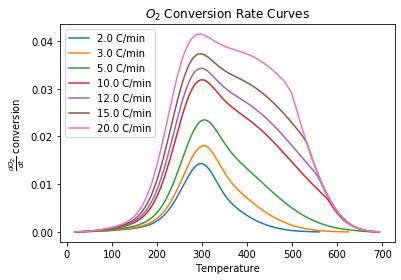

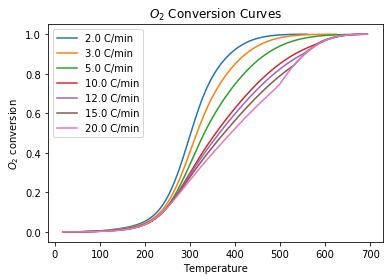

In [8]:
if not os.path.exists(os.path.join('results', 'synthetic_data_plots')):
    os.mkdir(os.path.join('results', 'synthetic_data_plots'))
nainterp = NonArrheniusInterp(oil_type='synthetic', experiment='namla_example_data',clean_data=False)
# naml_unc = NonArrheniusML(oil_type='synthetic', experiment='namla_example_data',clean_data=False)
naml_const = NonArrheniusML(oil_type='synthetic', experiment='namla_example_data',clean_data=False,constrained=True)

nainterp.print_consumption_curves(save_path=os.path.join('results','synthetic_data_plots','demo_data.png'))

Minimum conversion rate: -2.70045115368913e-17, maximum conversion rate: 0.04130419563928818


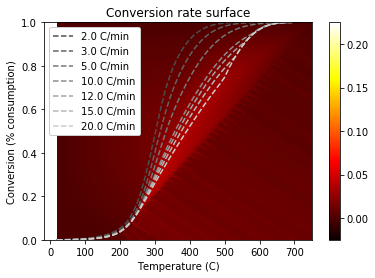

Minimum conversion rate: 0.0, maximum conversion rate: 0.3888618740865872


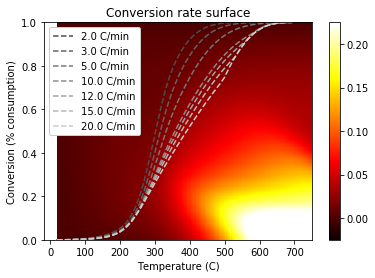

Minimum log-std. dev.: -9.807228122096436, maximum log-std. dev.: -4.5388958389612775


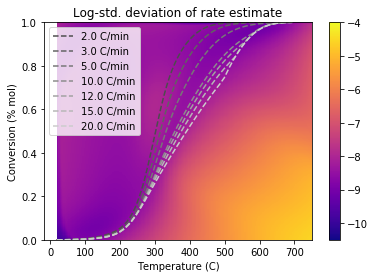

In [9]:
nainterp.print_surf_plot(save_path=os.path.join('results','synthetic_data_plots','interp_surf.png'),vmin=-0.025,vmax=0.225)
# naml_unc.print_surf_plot(save_path=os.path.join('results','synthetic_data_plots','namla_surf.png'),vmin=-0.025,vmax=0.225)
# naml_unc.print_uncertainty_surf(save_path=os.path.join('results','synthetic_data_plots','namla_uncert_surf.png'),vmin=-10.5,vmax=-4)
naml_const.print_surf_plot(save_path=os.path.join('results','synthetic_data_plots','namlac_surf.png'),vmin=-0.025,vmax=0.225)
naml_const.print_uncertainty_surf(save_path=os.path.join('results','synthetic_data_plots','namlac_uncert_surf.png'),vmin=-10.5,vmax=-4)

### Simulation with interpolated heating schedules
Train on heating schedules and interpolate for 6.0 C/min and 16.0 C/min

6.0


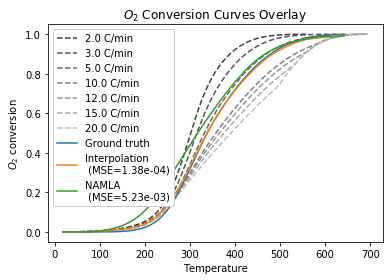

16.0


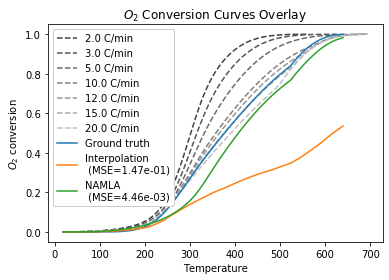

In [10]:
if not os.path.exists(os.path.join('results', 'synthetic_simulation_plots')):
    os.mkdir(os.path.join('results', 'synthetic_simulation_plots'))

# Load data
data_container = NonArrheniusInterp(oil_type='synthetic', experiment='namla_interpolation_data')

create_simulation_overlays(nainterp,
                           naml_const,
                           data_container,
                           os.path.join('results','synthetic_simulation_plots','interpolation.png'))



### Simulation with extrapolated heating schedules
Train on heating schedules excluding 25.0 and 30.0 and evaluate for these.

25.0


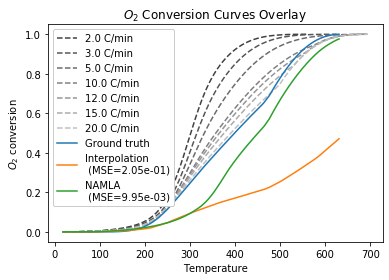

30.0


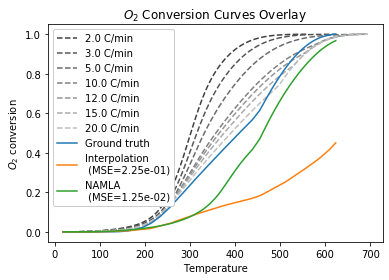

In [11]:
if not os.path.exists(os.path.join('results', 'synthetic_simulation_plots')):
    os.mkdir(os.path.join('results', 'synthetic_simulation_plots'))

# Load data
data_container = NonArrheniusInterp(oil_type='synthetic', experiment='namla_extrapolation_data')

create_simulation_overlays(nainterp,
                           naml_const,
                           data_container,
                           os.path.join('results','synthetic_simulation_plots','extrapolation.png'))


### Simulation with arbitrary heating schedule

schedule_0


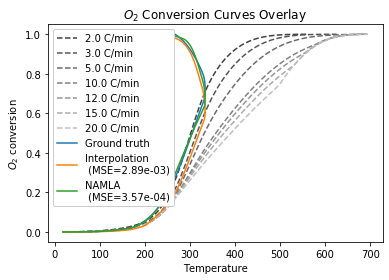

schedule_1


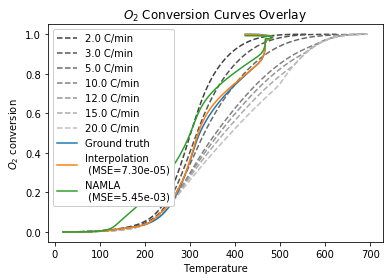

In [12]:
if not os.path.exists(os.path.join('results', 'synthetic_simulation_plots')):
    os.mkdir(os.path.join('results', 'synthetic_simulation_plots'))

# Load data
data_container = NonArrheniusInterp(oil_type='synthetic', experiment='namla_arbitrary_data', 
                                    clean_data=False)

create_simulation_overlays(nainterp,
                           naml_const,
                           data_container,
                           os.path.join('results','synthetic_simulation_plots','arbitrary.png'))
